In [2]:
import pandas as pd

# Load your dataset
df = pd.read_csv('/content/brain_tumor_dataset.csv')
print(df.head())


          Tumor Type        Location  Size (cm) Grade  Patient Age  Gender
0  Oligodendroglioma  Occipital Lobe       9.23     I           48  Female
1         Ependymoma  Occipital Lobe       0.87    II           47    Male
2         Meningioma  Occipital Lobe       2.33    II           12  Female
3         Ependymoma  Occipital Lobe       1.45   III           38  Female
4         Ependymoma       Brainstem       6.45     I           35  Female


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer # For combining transformers
from sklearn.pipeline import Pipeline # For chaining preprocessing and model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, roc_auc_score, precision_score, recall_score, f1_score
)

# --- 1. Data Loading and Preprocessing for the NEW Dataset ---
# Assuming your new dataset is also named 'Brain Tumor.csv' or you'll adjust the path
df = pd.read_csv('/content/brain_tumor_dataset.csv') # Adjust path if your new file is different

# Display first few rows and info for the NEW dataset
print("NEW Dataset DataFrame Head:")
print(df.head())
print("\nNEW Dataset DataFrame Info:")
df.info()
print("\nNEW Dataset Grade Distribution (before binarization):")
print(df['Grade'].value_counts())

# --- Define Features (X) and Target (y) ---
# Target variable: Binarize 'Grade'
# Let's define Grade I as 0, and Grade II/III as 1 for binary classification
grade_mapping = {'I': 0, 'II': 1, 'III': 1} # Extend if you have Grade IV etc.
df['Grade_Binary'] = df['Grade'].map(grade_mapping)

# Drop original 'Grade' and other non-feature columns
# 'Tumor Type', 'Location', 'Size (cm)', 'Patient Age', 'Gender' are features
X = df[['Tumor Type', 'Location', 'Size (cm)', 'Patient Age', 'Gender']]
y = df['Grade_Binary']

# Identify categorical and numerical columns for preprocessing
categorical_features = ['Tumor Type', 'Location', 'Gender']
numerical_features = ['Size (cm)', 'Patient Age']

# Create a preprocessor using ColumnTransformer
# This will apply StandardScaler to numerical features and OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split dataset into train and test sets (80-20)
# Ensure to split BEFORE applying preprocessor to avoid data leakage
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# Get the number of features after one-hot encoding for ELM input_size
input_size_elm = X_train.shape[1]

print(f"\nShape of X_train after preprocessing: {X_train.shape}")
print(f"Shape of X_test after preprocessing: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"ELM input size (number of features after encoding): {input_size_elm}")


# --- 2. ELM Class Definition (No change needed here from previous version) ---
class ELM:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_weights = np.random.randn(self.input_size, self.hidden_size)
        self.bias = np.random.randn(self.hidden_size)
        self.output_weights = None
        self.one_hot = False
        self.classes = None

    def _activation(self, x):
        return 1 / (1 + np.exp(-x))  # Sigmoid activation

    def fit(self, X, y):
        # The target 'y' is already binarized (0/1), so no one-hot encoding for binary case
        self.one_hot = False
        y_reshaped = np.array(y).reshape(-1, 1)

        H = self._activation(np.dot(X, self.input_weights) + self.bias)
        regularization_term = 1e-6 * np.eye(H.shape[1])
        self.output_weights = np.dot(np.linalg.pinv(H.T @ H + regularization_term) @ H.T, y_reshaped)

    def predict(self, X, return_probabilities=False):
        H = self._activation(np.dot(X, self.input_weights) + self.bias)
        y_pred = np.dot(H, self.output_weights)
        if return_probabilities:
            return 1 / (1 + np.exp(-y_pred)).flatten()
        else:
            return (y_pred > 0.5).astype(int).flatten()

# --- 3. Optimization Algorithm Fitness Functions (No change) ---

# Fitness function for Decision Tree
def fitness_function_dt(params, X_train, y_train, X_val, y_val):
    max_depth = int(params[0])
    min_samples_split = int(params[1])
    max_depth = max(1, min(max_depth, 50))
    min_samples_split = max(2, min(min_samples_split, 50))
    clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return 1 - accuracy_score(y_val, y_pred)

# Fitness function for ELM
def fitness_function_elm(hidden_size_param, X_train, y_train, X_val, y_val):
    hidden_size = int(hidden_size_param[0])
    hidden_size = max(1, min(hidden_size, 500))
    elm = ELM(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1)
    elm.fit(X_train, y_train)
    y_pred = elm.predict(X_val, return_probabilities=False)
    return 1 - accuracy_score(y_val, y_pred)

# --- 4. Honey Badger Algorithm (HBA) (No change) ---
def honey_badger_optimizer(X_train, y_train, X_val, y_val, fitness_func, param_bounds, n_agents=10, max_iter=20):
    dim = len(param_bounds[0])
    lb = np.array(param_bounds[0])
    ub = np.array(param_bounds[1])

    agents = np.random.uniform(low=lb, high=ub, size=(n_agents, dim))
    best_fitness = float("inf")
    best_position = None

    for iter_num in range(max_iter):
        alpha = 2 * np.exp(-4 * (iter_num / max_iter) ** 2)
        for i in range(n_agents):
            fitness = fitness_func(agents[i], X_train, y_train, X_val, y_val)
            if fitness < best_fitness:
                best_fitness = fitness
                best_position = agents[i].copy()
        for i in range(n_agents):
            F = alpha * np.random.rand()
            rand_agent_idx = np.random.randint(n_agents)
            while rand_agent_idx == i:
                rand_agent_idx = np.random.randint(n_agents)
            rand_agent = agents[rand_agent_idx]

            if np.random.rand() < 0.5:
                agents[i] += F * (rand_agent - agents[i])
            else:
                agents[i] += F * (best_position - agents[i]) + np.random.randn(dim) * (ub - lb) * 0.01
            agents[i] = np.clip(agents[i], lb, ub)
    return best_position.astype(int) if dim > 1 else int(best_position[0])

# --- 5. Salp Swarm Algorithm (SSA) (No change) ---
def salp_swarm_optimizer(X_train, y_train, X_val, y_val, fitness_func, param_bounds, n_salps=10, max_iter=20):
    dim = len(param_bounds[0])
    lb = np.array(param_bounds[0])
    ub = np.array(param_bounds[1])

    salps = np.random.uniform(low=lb, high=ub, size=(n_salps, dim))
    food_position = None
    food_fitness = float("inf")

    for iter_num in range(max_iter):
        c1 = 2 * np.exp(-(4 * iter_num / max_iter) ** 2)
        for i in range(n_salps):
            fitness = fitness_func(salps[i], X_train, y_train, X_val, y_val)
            if fitness < food_fitness:
                food_fitness = fitness
                food_position = salps[i].copy()
        for i in range(n_salps):
            for j in range(dim):
                if i == 0:
                    c2 = np.random.rand()
                    c3 = np.random.rand()
                    if c3 < 0.5:
                        salps[i, j] = food_position[j] + c1 * ((ub[j] - lb[j]) * c2 + lb[j])
                    else:
                        salps[i, j] = food_position[j] - c1 * ((ub[j] - lb[j]) * c2 + lb[j])
                else:
                    salps[i, j] = (salps[i, j] + salps[i - 1, j]) / 2.0
            salps[i] = np.clip(salps[i], lb, ub)
    return food_position.astype(int) if dim > 1 else int(food_position[0])

# --- 6. Metric Calculation Helper (No change) ---
def calculate_metrics(y_true, y_pred, y_proba):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    precision = report['1']['precision'] if '1' in report else 0
    recall = report['1']['recall'] if '1' in report else 0
    f1 = report['1']['f1-score'] if '1' in report else 0

    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = 0, 0, 0, 0
    if cm.shape == (2, 2):
        TN, FP, FN, TP = cm.ravel()
    else:
        print(f"Warning: Confusion matrix shape is {cm.shape}, not 2x2 for binary classification. Sensitivity/Specificity might be inaccurate for {cm}.")

    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    roc_auc = roc_auc_score(y_true, y_proba)
    fpr, tpr, _ = roc_curve(y_true, y_proba)

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'AUC': roc_auc,
        'FPR': fpr,
        'TPR': tpr
    }

# --- 7. Prepare for Optimization: Train-validation split ---
# This split is used by the optimization algorithms to find best hyperparameters
X_sub_train, X_val, y_sub_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

all_model_metrics = {}

print("\n--- Running Baseline Models ---")
# 1. Decision Tree (Baseline)
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train, y_train)
y_pred_dt_baseline = dt_baseline.predict(X_test)
y_proba_dt_baseline = dt_baseline.predict_proba(X_test)[:, 1]
all_model_metrics['Decision Tree (Baseline)'] = calculate_metrics(y_test, y_pred_dt_baseline, y_proba_dt_baseline)
print("Decision Tree (Baseline) trained.")

# 2. ELM (Baseline)
# Use the input_size_elm derived from preprocessed data
elm_baseline = ELM(input_size=input_size_elm, hidden_size=100, output_size=1)
elm_baseline.fit(X_train, y_train)
y_pred_elm_baseline = elm_baseline.predict(X_test, return_probabilities=False)
y_proba_elm_baseline = elm_baseline.predict(X_test, return_probabilities=True)
all_model_metrics['ELM (Baseline)'] = calculate_metrics(y_test, y_pred_elm_baseline, y_proba_elm_baseline)
print("ELM (Baseline) trained.")

print("\n--- Running Optimized Models (this may take some time) ---")
# Parameter bounds for DT (max_depth, min_samples_split)
dt_param_bounds = ([1, 2], [50, 50])
# Parameter bounds for ELM (hidden_size)
elm_param_bounds = ([10], [500])

# 3. Decision Tree (HBA-Optimized)
print("Optimizing Decision Tree with HBA...")
best_params_dt_hba = honey_badger_optimizer(
    X_sub_train, y_sub_train, X_val, y_val,
    fitness_func=fitness_function_dt, param_bounds=dt_param_bounds,
    n_agents=15, max_iter=30
)
print(f"HBA-Optimized DT Params: max_depth={best_params_dt_hba[0]}, min_samples_split={best_params_dt_hba[1]}")
dt_hba = DecisionTreeClassifier(max_depth=best_params_dt_hba[0], min_samples_split=best_params_dt_hba[1], random_state=42)
dt_hba.fit(X_train, y_train)
y_pred_dt_hba = dt_hba.predict(X_test)
y_proba_dt_hba = dt_hba.predict_proba(X_test)[:, 1]
all_model_metrics['Decision Tree (HBA)'] = calculate_metrics(y_test, y_pred_dt_hba, y_proba_dt_hba)
print("Decision Tree (HBA) trained.")


# 4. Decision Tree (SSA-Optimized)
print("\nOptimizing Decision Tree with SSA...")
best_params_dt_ssa = salp_swarm_optimizer(
    X_sub_train, y_sub_train, X_val, y_val,
    fitness_func=fitness_function_dt, param_bounds=dt_param_bounds,
    n_salps=15, max_iter=30
)
print(f"SSA-Optimized DT Params: max_depth={best_params_dt_ssa[0]}, min_samples_split={best_params_dt_ssa[1]}")
dt_ssa = DecisionTreeClassifier(max_depth=best_params_dt_ssa[0], min_samples_split=best_params_dt_ssa[1], random_state=42)
dt_ssa.fit(X_train, y_train)
y_pred_dt_ssa = dt_ssa.predict(X_test)
y_proba_dt_ssa = dt_ssa.predict_proba(X_test)[:, 1]
all_model_metrics['Decision Tree (SSA)'] = calculate_metrics(y_test, y_pred_dt_ssa, y_proba_dt_ssa)
print("Decision Tree (SSA) trained.")


# 5. ELM (HBA-Optimized)
print("\nOptimizing ELM with HBA...")
best_hidden_hba_elm = honey_badger_optimizer(
    X_sub_train, y_sub_train, X_val, y_val,
    fitness_func=fitness_function_elm, param_bounds=elm_param_bounds,
    n_agents=15, max_iter=30
)
print(f"HBA-Optimized ELM Hidden Size: {best_hidden_hba_elm}")
elm_hba = ELM(input_size=input_size_elm, hidden_size=best_hidden_hba_elm, output_size=1)
elm_hba.fit(X_train, y_train)
y_pred_elm_hba = elm_hba.predict(X_test, return_probabilities=False)
y_proba_elm_hba = elm_hba.predict(X_test, return_probabilities=True)
all_model_metrics['ELM Optimized (HBA)'] = calculate_metrics(y_test, y_pred_elm_hba, y_proba_elm_hba)
print("ELM Optimized (HBA) trained.")


# 6. ELM (SSA-Optimized)
print("\nOptimizing ELM with SSA...")
best_hidden_ssa_elm = salp_swarm_optimizer(
    X_sub_train, y_sub_train, X_val, y_val,
    fitness_func=fitness_function_elm, param_bounds=elm_param_bounds,
    n_salps=15, max_iter=30
)
print(f"SSA-Optimized ELM Hidden Size: {best_hidden_ssa_elm}")
elm_ssa = ELM(input_size=input_size_elm, hidden_size=best_hidden_ssa_elm, output_size=1)
elm_ssa.fit(X_train, y_train)
y_pred_elm_ssa = elm_ssa.predict(X_test, return_probabilities=False)
y_proba_elm_ssa = elm_ssa.predict(X_test, return_probabilities=True)
all_model_metrics['ELM Optimized (SSA)'] = calculate_metrics(y_test, y_pred_elm_ssa, y_proba_elm_ssa)
print("ELM Optimized (SSA) trained.")


# --- 8. Consolidated Parameter Summary Table ---
print("\n" + "="*90)
print("                     Comprehensive Model Performance Summary")
print("="*90)
header = "{:<30} {:>10} {:>10} {:>10} {:>10} {:>10} {:>10} {:>8}".format(
    "Model", "Accuracy", "Precision", "Recall", "F1-Score", "Sensitivity", "Specificity", "AUC"
)
print(header)
print("-" * 90)

for model_name, metrics in all_model_metrics.items():
    print("{:<30} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.4f} {:>8.4f}".format(
        model_name,
        metrics['Accuracy'],
        metrics['Precision'],
        metrics['Recall'],
        metrics['F1-Score'],
        metrics['Sensitivity'],
        metrics['Specificity'],
        metrics['AUC']
    ))
print("="*90)

# --- 9. Separate ROC Plots for Each Model ---
print("\n--- Plotting Individual ROC Curves ---")
for model_name, metrics in all_model_metrics.items():
    plt.figure(figsize=(8, 6))
    plt.plot(metrics['FPR'], metrics['TPR'], color='darkorange', lw=2,
             label=f'ROC curve (AUC = {metrics["AUC"]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random classifier
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

print("\nAll plots generated.")

NEW Dataset DataFrame Head:
          Tumor Type        Location  Size (cm) Grade  Patient Age  Gender
0  Oligodendroglioma  Occipital Lobe       9.23     I           48  Female
1         Ependymoma  Occipital Lobe       0.87    II           47    Male
2         Meningioma  Occipital Lobe       2.33    II           12  Female
3         Ependymoma  Occipital Lobe       1.45   III           38  Female
4         Ependymoma       Brainstem       6.45     I           35  Female

NEW Dataset DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tumor Type   1000 non-null   object 
 1   Location     1000 non-null   object 
 2   Size (cm)    1000 non-null   float64
 3   Grade        1000 non-null   object 
 4   Patient Age  1000 non-null   int64  
 5   Gender       1000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage

ValueError: Input y contains NaN.

NEW Dataset DataFrame Head:
          Tumor Type        Location  Size (cm) Grade  Patient Age  Gender
0  Oligodendroglioma  Occipital Lobe       9.23     I           48  Female
1         Ependymoma  Occipital Lobe       0.87    II           47    Male
2         Meningioma  Occipital Lobe       2.33    II           12  Female
3         Ependymoma  Occipital Lobe       1.45   III           38  Female
4         Ependymoma       Brainstem       6.45     I           35  Female

NEW Dataset DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tumor Type   1000 non-null   object 
 1   Location     1000 non-null   object 
 2   Size (cm)    1000 non-null   float64
 3   Grade        1000 non-null   object 
 4   Patient Age  1000 non-null   int64  
 5   Gender       1000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage

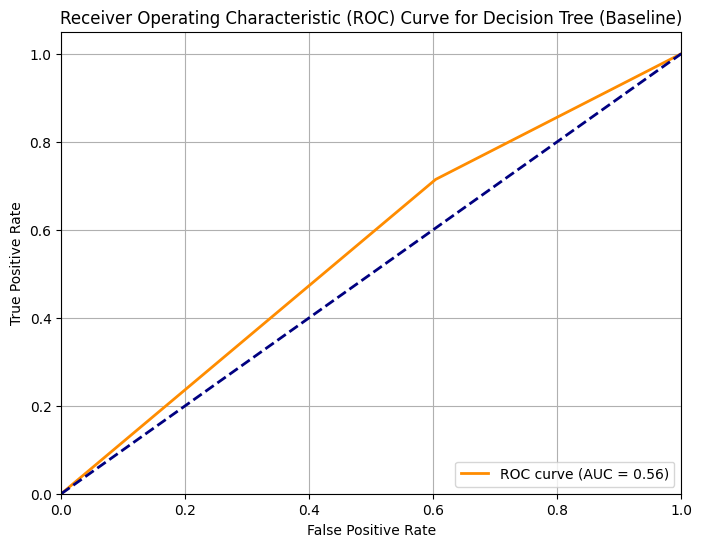

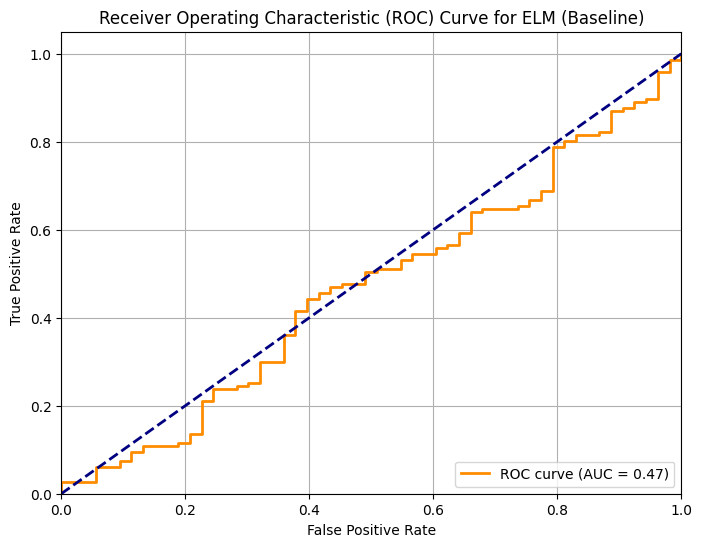

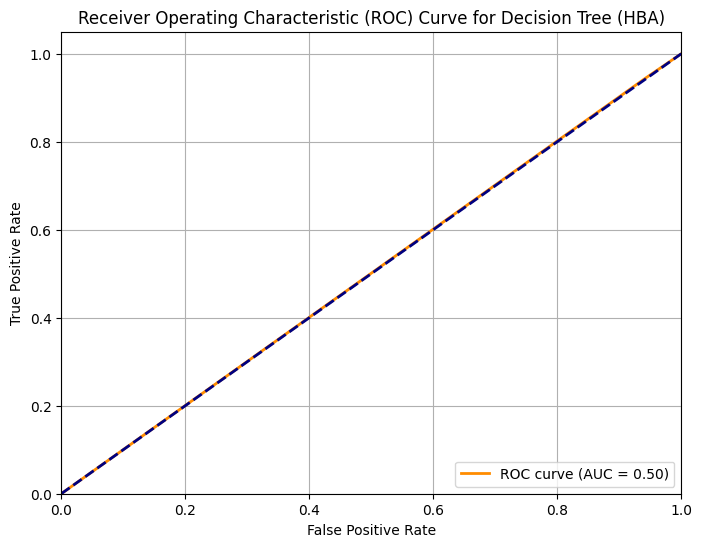

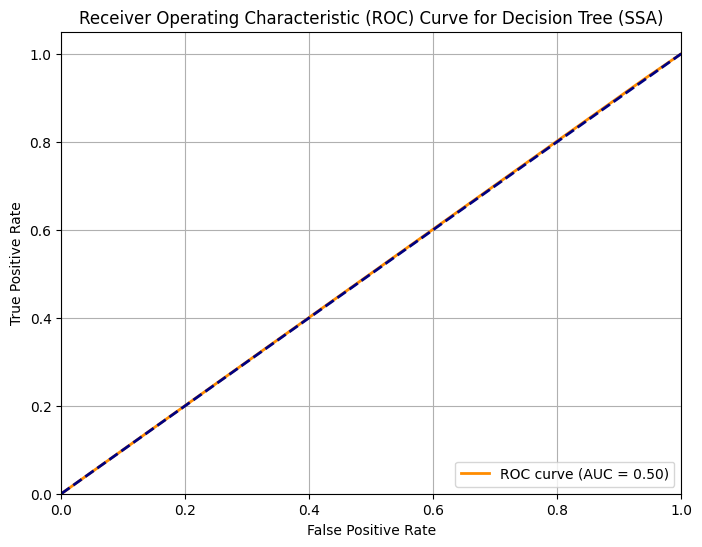

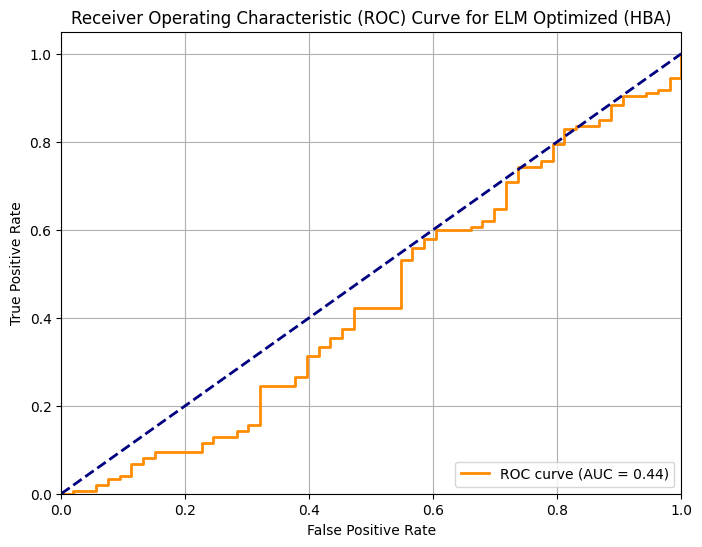

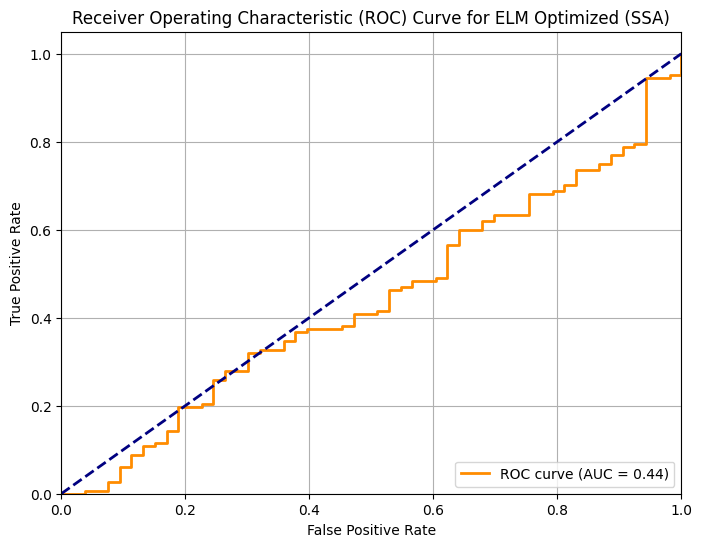


All plots generated.


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer # For combining transformers
from sklearn.pipeline import Pipeline # For chaining preprocessing and model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, roc_auc_score, precision_score, recall_score, f1_score
)

# --- 1. Data Loading and Preprocessing for the NEW Dataset ---
# Assuming your new dataset is also named 'Brain Tumor.csv' or you'll adjust the path
df = pd.read_csv('/content/brain_tumor_dataset.csv') # Adjust path if your new file is different

# Display first few rows and info for the NEW dataset
print("NEW Dataset DataFrame Head:")
print(df.head())
print("\nNEW Dataset DataFrame Info:")
df.info()
print("\nNEW Dataset Grade Distribution (before binarization):")
print(df['Grade'].value_counts())

# --- Define Features (X) and Target (y) ---
# Target variable: Binarize 'Grade'
# Let's define Grade I as 0, and Grade II/III/IV as 1 for binary classification
# FIX: Added 'IV' to the grade_mapping
grade_mapping = {'I': 0, 'II': 1, 'III': 1, 'IV': 1}
df['Grade_Binary'] = df['Grade'].map(grade_mapping)

# Check for NaNs after mapping (should be none now if all grades are covered)
print("\nGrade_Binary Distribution (after mapping):")
print(df['Grade_Binary'].value_counts())
print(f"NaNs in Grade_Binary after mapping: {df['Grade_Binary'].isnull().sum()}")


# Drop original 'Grade' and other non-feature columns
# 'Tumor Type', 'Location', 'Size (cm)', 'Patient Age', 'Gender' are features
X = df[['Tumor Type', 'Location', 'Size (cm)', 'Patient Age', 'Gender']]
y = df['Grade_Binary']

# Identify categorical and numerical columns for preprocessing
categorical_features = ['Tumor Type', 'Location', 'Gender']
numerical_features = ['Size (cm)', 'Patient Age']

# Create a preprocessor using ColumnTransformer
# This will apply StandardScaler to numerical features and OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split dataset into train and test sets (80-20)
# Ensure to split BEFORE applying preprocessor to avoid data leakage
# The y now has no NaNs, so this split will work
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# Get the number of features after one-hot encoding for ELM input_size
input_size_elm = X_train.shape[1]

print(f"\nShape of X_train after preprocessing: {X_train.shape}")
print(f"Shape of X_test after preprocessing: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"ELM input size (number of features after encoding): {input_size_elm}")


# --- 2. ELM Class Definition (No change needed here from previous version) ---
class ELM:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_weights = np.random.randn(self.input_size, self.hidden_size)
        self.bias = np.random.randn(self.hidden_size)
        self.output_weights = None
        self.one_hot = False
        self.classes = None

    def _activation(self, x):
        return 1 / (1 + np.exp(-x))  # Sigmoid activation

    def fit(self, X, y):
        self.one_hot = False
        y_reshaped = np.array(y).reshape(-1, 1)

        H = self._activation(np.dot(X, self.input_weights) + self.bias)
        regularization_term = 1e-6 * np.eye(H.shape[1])
        self.output_weights = np.dot(np.linalg.pinv(H.T @ H + regularization_term) @ H.T, y_reshaped)

    def predict(self, X, return_probabilities=False):
        H = self._activation(np.dot(X, self.input_weights) + self.bias)
        y_pred = np.dot(H, self.output_weights)
        if return_probabilities:
            return 1 / (1 + np.exp(-y_pred)).flatten()
        else:
            return (y_pred > 0.5).astype(int).flatten()

# --- 3. Optimization Algorithm Fitness Functions (No change) ---

# Fitness function for Decision Tree
def fitness_function_dt(params, X_train, y_train, X_val, y_val):
    max_depth = int(params[0])
    min_samples_split = int(params[1])
    max_depth = max(1, min(max_depth, 50))
    min_samples_split = max(2, min(min_samples_split, 50))
    clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return 1 - accuracy_score(y_val, y_pred)

# Fitness function for ELM
def fitness_function_elm(hidden_size_param, X_train, y_train, X_val, y_val):
    hidden_size = int(hidden_size_param[0])
    hidden_size = max(1, min(hidden_size, 500))
    elm = ELM(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1)
    elm.fit(X_train, y_train)
    y_pred = elm.predict(X_val, return_probabilities=False)
    return 1 - accuracy_score(y_val, y_pred)

# --- 4. Honey Badger Algorithm (HBA) (No change) ---
def honey_badger_optimizer(X_train, y_train, X_val, y_val, fitness_func, param_bounds, n_agents=10, max_iter=20):
    dim = len(param_bounds[0])
    lb = np.array(param_bounds[0])
    ub = np.array(param_bounds[1])

    agents = np.random.uniform(low=lb, high=ub, size=(n_agents, dim))
    best_fitness = float("inf")
    best_position = None

    for iter_num in range(max_iter):
        alpha = 2 * np.exp(-4 * (iter_num / max_iter) ** 2)
        for i in range(n_agents):
            fitness = fitness_func(agents[i], X_train, y_train, X_val, y_val)
            if fitness < best_fitness:
                best_fitness = fitness
                best_position = agents[i].copy()
        for i in range(n_agents):
            F = alpha * np.random.rand()
            rand_agent_idx = np.random.randint(n_agents)
            while rand_agent_idx == i:
                rand_agent_idx = np.random.randint(n_agents)
            rand_agent = agents[rand_agent_idx]

            if np.random.rand() < 0.5:
                agents[i] += F * (rand_agent - agents[i])
            else:
                agents[i] += F * (best_position - agents[i]) + np.random.randn(dim) * (ub - lb) * 0.01
            agents[i] = np.clip(agents[i], lb, ub)
    return best_position.astype(int) if dim > 1 else int(best_position[0])

# --- 5. Salp Swarm Algorithm (SSA) (No change) ---
def salp_swarm_optimizer(X_train, y_train, X_val, y_val, fitness_func, param_bounds, n_salps=10, max_iter=20):
    dim = len(param_bounds[0])
    lb = np.array(param_bounds[0])
    ub = np.array(param_bounds[1])

    salps = np.random.uniform(low=lb, high=ub, size=(n_salps, dim))
    food_position = None
    food_fitness = float("inf")

    for iter_num in range(max_iter):
        c1 = 2 * np.exp(-(4 * iter_num / max_iter) ** 2)
        for i in range(n_salps):
            fitness = fitness_func(salps[i], X_train, y_train, X_val, y_val)
            if fitness < food_fitness:
                food_fitness = fitness
                food_position = salps[i].copy()
        for i in range(n_salps):
            for j in range(dim):
                if i == 0:
                    c2 = np.random.rand()
                    c3 = np.random.rand()
                    if c3 < 0.5:
                        salps[i, j] = food_position[j] + c1 * ((ub[j] - lb[j]) * c2 + lb[j])
                    else:
                        salps[i, j] = food_position[j] - c1 * ((ub[j] - lb[j]) * c2 + lb[j])
                else:
                    salps[i, j] = (salps[i, j] + salps[i - 1, j]) / 2.0
            salps[i] = np.clip(salps[i], lb, ub)
    return food_position.astype(int) if dim > 1 else int(food_position[0])

# --- 6. Metric Calculation Helper (No change) ---
def calculate_metrics(y_true, y_pred, y_proba):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    precision = report['1']['precision'] if '1' in report else 0
    recall = report['1']['recall'] if '1' in report else 0
    f1 = report['1']['f1-score'] if '1' in report else 0

    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = 0, 0, 0, 0
    if cm.shape == (2, 2):
        TN, FP, FN, TP = cm.ravel()
    else:
        print(f"Warning: Confusion matrix shape is {cm.shape}, not 2x2 for binary classification. Sensitivity/Specificity might be inaccurate for {cm}.")

    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    roc_auc = roc_auc_score(y_true, y_proba)
    fpr, tpr, _ = roc_curve(y_true, y_proba)

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'AUC': roc_auc,
        'FPR': fpr,
        'TPR': tpr
    }

# --- 7. Prepare for Optimization: Train-validation split ---
# This split is used by the optimization algorithms to find best hyperparameters
X_sub_train, X_val, y_sub_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

all_model_metrics = {}

print("\n--- Running Baseline Models ---")
# 1. Decision Tree (Baseline)
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train, y_train)
y_pred_dt_baseline = dt_baseline.predict(X_test)
y_proba_dt_baseline = dt_baseline.predict_proba(X_test)[:, 1]
all_model_metrics['Decision Tree (Baseline)'] = calculate_metrics(y_test, y_pred_dt_baseline, y_proba_dt_baseline)
print("Decision Tree (Baseline) trained.")

# 2. ELM (Baseline)
# Use the input_size_elm derived from preprocessed data
elm_baseline = ELM(input_size=input_size_elm, hidden_size=100, output_size=1)
elm_baseline.fit(X_train, y_train)
y_pred_elm_baseline = elm_baseline.predict(X_test, return_probabilities=False)
y_proba_elm_baseline = elm_baseline.predict(X_test, return_probabilities=True)
all_model_metrics['ELM (Baseline)'] = calculate_metrics(y_test, y_pred_elm_baseline, y_proba_elm_baseline)
print("ELM (Baseline) trained.")

print("\n--- Running Optimized Models (this may take some time) ---")
# Parameter bounds for DT (max_depth, min_samples_split)
dt_param_bounds = ([1, 2], [50, 50])
# Parameter bounds for ELM (hidden_size)
elm_param_bounds = ([10], [500])

# 3. Decision Tree (HBA-Optimized)
print("Optimizing Decision Tree with HBA...")
best_params_dt_hba = honey_badger_optimizer(
    X_sub_train, y_sub_train, X_val, y_val,
    fitness_func=fitness_function_dt, param_bounds=dt_param_bounds,
    n_agents=15, max_iter=30
)
print(f"HBA-Optimized DT Params: max_depth={best_params_dt_hba[0]}, min_samples_split={best_params_dt_hba[1]}")
dt_hba = DecisionTreeClassifier(max_depth=best_params_dt_hba[0], min_samples_split=best_params_dt_hba[1], random_state=42)
dt_hba.fit(X_train, y_train)
y_pred_dt_hba = dt_hba.predict(X_test)
y_proba_dt_hba = dt_hba.predict_proba(X_test)[:, 1]
all_model_metrics['Decision Tree (HBA)'] = calculate_metrics(y_test, y_pred_dt_hba, y_proba_dt_hba)
print("Decision Tree (HBA) trained.")


# 4. Decision Tree (SSA-Optimized)
print("\nOptimizing Decision Tree with SSA...")
best_params_dt_ssa = salp_swarm_optimizer(
    X_sub_train, y_sub_train, X_val, y_val,
    fitness_func=fitness_function_dt, param_bounds=dt_param_bounds,
    n_salps=15, max_iter=30
)
print(f"SSA-Optimized DT Params: max_depth={best_params_dt_ssa[0]}, min_samples_split={best_params_dt_ssa[1]}")
dt_ssa = DecisionTreeClassifier(max_depth=best_params_dt_ssa[0], min_samples_split=best_params_dt_ssa[1], random_state=42)
dt_ssa.fit(X_train, y_train)
y_pred_dt_ssa = dt_ssa.predict(X_test)
y_proba_dt_ssa = dt_ssa.predict_proba(X_test)[:, 1]
all_model_metrics['Decision Tree (SSA)'] = calculate_metrics(y_test, y_pred_dt_ssa, y_proba_dt_ssa)
print("Decision Tree (SSA) trained.")


# 5. ELM (HBA-Optimized)
print("\nOptimizing ELM with HBA...")
best_hidden_hba_elm = honey_badger_optimizer(
    X_sub_train, y_sub_train, X_val, y_val,
    fitness_func=fitness_function_elm, param_bounds=elm_param_bounds,
    n_agents=15, max_iter=30
)
print(f"HBA-Optimized ELM Hidden Size: {best_hidden_hba_elm}")
elm_hba = ELM(input_size=input_size_elm, hidden_size=best_hidden_hba_elm, output_size=1)
elm_hba.fit(X_train, y_train)
y_pred_elm_hba = elm_hba.predict(X_test, return_probabilities=False)
y_proba_elm_hba = elm_hba.predict(X_test, return_probabilities=True)
all_model_metrics['ELM Optimized (HBA)'] = calculate_metrics(y_test, y_pred_elm_hba, y_proba_elm_hba)
print("ELM Optimized (HBA) trained.")


# 6. ELM (SSA-Optimized)
print("\nOptimizing ELM with SSA...")
best_hidden_ssa_elm = salp_swarm_optimizer(
    X_sub_train, y_sub_train, X_val, y_val,
    fitness_func=fitness_function_elm, param_bounds=elm_param_bounds,
    n_salps=15, max_iter=30
)
print(f"SSA-Optimized ELM Hidden Size: {best_hidden_ssa_elm}")
elm_ssa = ELM(input_size=input_size_elm, hidden_size=best_hidden_ssa_elm, output_size=1)
elm_ssa.fit(X_train, y_train)
y_pred_elm_ssa = elm_ssa.predict(X_test, return_probabilities=False)
y_proba_elm_ssa = elm_ssa.predict(X_test, return_probabilities=True)
all_model_metrics['ELM Optimized (SSA)'] = calculate_metrics(y_test, y_pred_elm_ssa, y_proba_elm_ssa)
print("ELM Optimized (SSA) trained.")


# --- 8. Consolidated Parameter Summary Table ---
print("\n" + "="*90)
print("                     Comprehensive Model Performance Summary")
print("="*90)
header = "{:<30} {:>10} {:>10} {:>10} {:>10} {:>10} {:>10} {:>8}".format(
    "Model", "Accuracy", "Precision", "Recall", "F1-Score", "Sensitivity", "Specificity", "AUC"
)
print(header)
print("-" * 90)

for model_name, metrics in all_model_metrics.items():
    print("{:<30} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.4f} {:>8.4f}".format(
        model_name,
        metrics['Accuracy'],
        metrics['Precision'],
        metrics['Recall'],
        metrics['F1-Score'],
        metrics['Sensitivity'],
        metrics['Specificity'],
        metrics['AUC']
    ))
print("="*90)

# --- 9. Separate ROC Plots for Each Model ---
print("\n--- Plotting Individual ROC Curves ---")
for model_name, metrics in all_model_metrics.items():
    plt.figure(figsize=(8, 6))
    plt.plot(metrics['FPR'], metrics['TPR'], color='darkorange', lw=2,
             label=f'ROC curve (AUC = {metrics["AUC"]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random classifier
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

print("\nAll plots generated.")

NEW Dataset DataFrame Head:
          Tumor Type        Location  Size (cm) Grade  Patient Age  Gender
0  Oligodendroglioma  Occipital Lobe       9.23     I           48  Female
1         Ependymoma  Occipital Lobe       0.87    II           47    Male
2         Meningioma  Occipital Lobe       2.33    II           12  Female
3         Ependymoma  Occipital Lobe       1.45   III           38  Female
4         Ependymoma       Brainstem       6.45     I           35  Female

NEW Dataset DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Tumor Type   1000 non-null   object 
 1   Location     1000 non-null   object 
 2   Size (cm)    1000 non-null   float64
 3   Grade        1000 non-null   object 
 4   Patient Age  1000 non-null   int64  
 5   Gender       1000 non-null   object 
dtypes: float64(1), int64(1), object(4)
memory usage

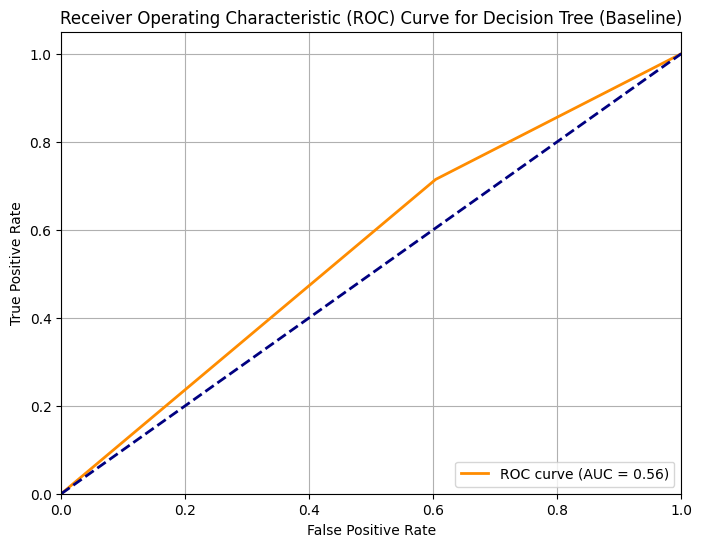

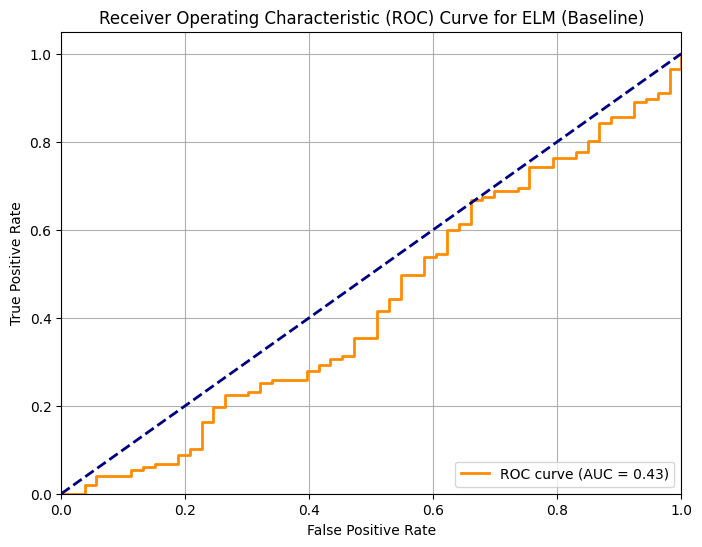

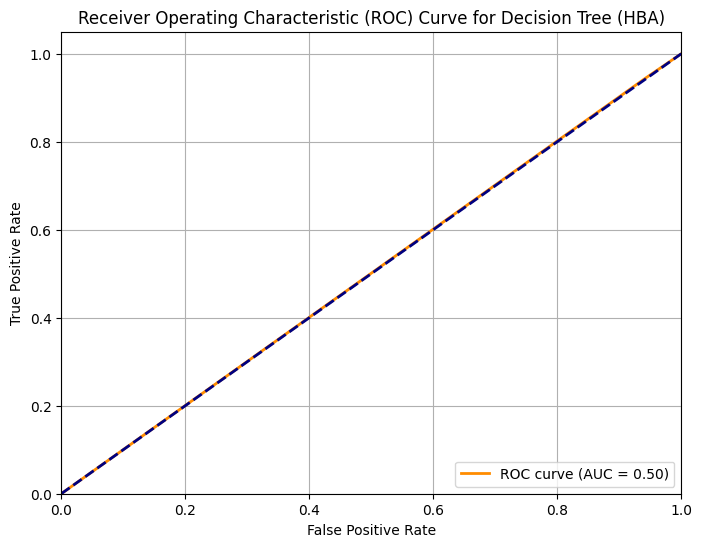

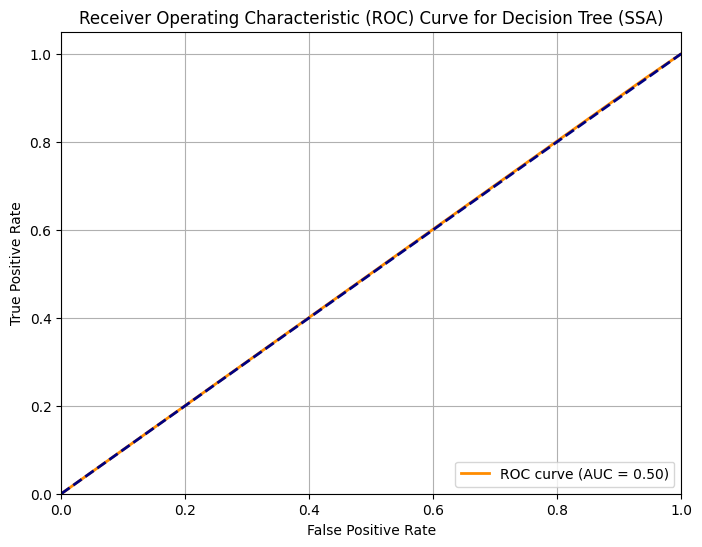

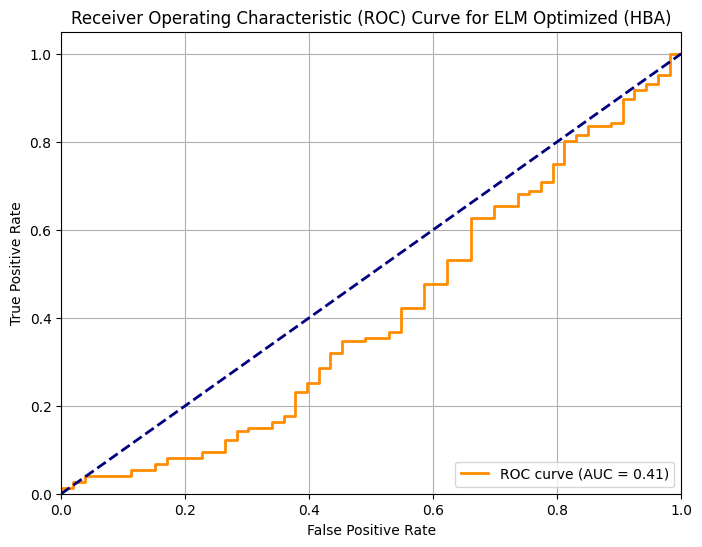

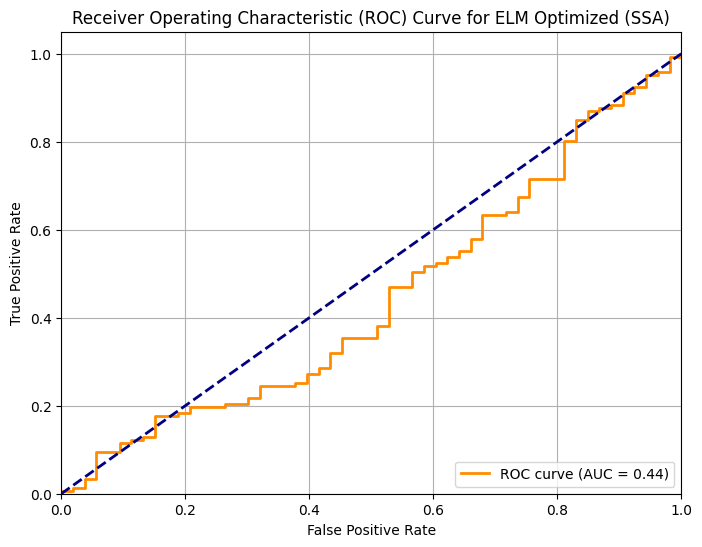


--- Plotting Consolidated ROC Curve for All Models ---


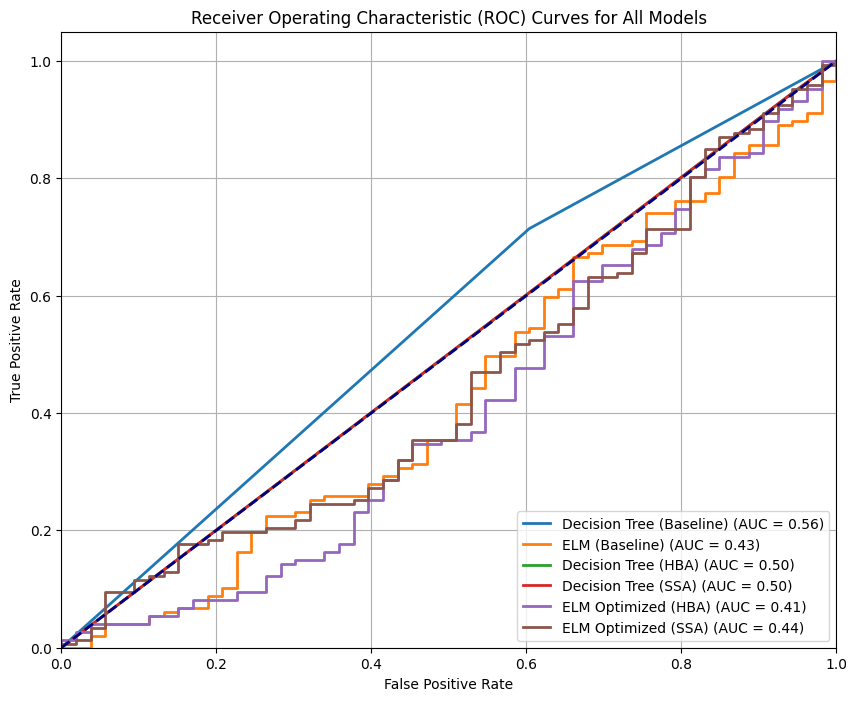


All plots generated.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer # For combining transformers
from sklearn.pipeline import Pipeline # For chaining preprocessing and model
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, roc_auc_score, precision_score, recall_score, f1_score
)

# --- 1. Data Loading and Preprocessing for the NEW Dataset ---
# Assuming your new dataset is also named 'Brain Tumor.csv' or you'll adjust the path
df = pd.read_csv('/content/brain_tumor_dataset.csv') # Adjust path if your new file is different

# Display first few rows and info for the NEW dataset
print("NEW Dataset DataFrame Head:")
print(df.head())
print("\nNEW Dataset DataFrame Info:")
df.info()
print("\nNEW Dataset Grade Distribution (before binarization):")
print(df['Grade'].value_counts())

# --- Define Features (X) and Target (y) ---
# Target variable: Binarize 'Grade'
# Let's define Grade I as 0, and Grade II/III/IV as 1 for binary classification
# FIX: Added 'IV' to the grade_mapping
grade_mapping = {'I': 0, 'II': 1, 'III': 1, 'IV': 1}
df['Grade_Binary'] = df['Grade'].map(grade_mapping)

# Check for NaNs after mapping (should be none now if all grades are covered)
print("\nGrade_Binary Distribution (after mapping):")
print(df['Grade_Binary'].value_counts())
print(f"NaNs in Grade_Binary after mapping: {df['Grade_Binary'].isnull().sum()}")


# Drop original 'Grade' and other non-feature columns
# 'Tumor Type', 'Location', 'Size (cm)', 'Patient Age', 'Gender' are features
X = df[['Tumor Type', 'Location', 'Size (cm)', 'Patient Age', 'Gender']]
y = df['Grade_Binary']

# Identify categorical and numerical columns for preprocessing
categorical_features = ['Tumor Type', 'Location', 'Gender']
numerical_features = ['Size (cm)', 'Patient Age']

# Create a preprocessor using ColumnTransformer
# This will apply StandardScaler to numerical features and OneHotEncoder to categorical features
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Split dataset into train and test sets (80-20)
# Ensure to split BEFORE applying preprocessor to avoid data leakage
# The y now has no NaNs, so this split will work
X_train_raw, X_test_raw, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Apply preprocessing
X_train = preprocessor.fit_transform(X_train_raw)
X_test = preprocessor.transform(X_test_raw)

# Get the number of features after one-hot encoding for ELM input_size
input_size_elm = X_train.shape[1]

print(f"\nShape of X_train after preprocessing: {X_train.shape}")
print(f"Shape of X_test after preprocessing: {X_test.shape}")
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")
print(f"ELM input size (number of features after encoding): {input_size_elm}")


# --- 2. ELM Class Definition (No change needed here from previous version) ---
class ELM:
    def __init__(self, input_size, hidden_size, output_size):
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.input_weights = np.random.randn(self.input_size, self.hidden_size)
        self.bias = np.random.randn(self.hidden_size)
        self.output_weights = None
        self.one_hot = False
        self.classes = None

    def _activation(self, x):
        return 1 / (1 + np.exp(-x))  # Sigmoid activation

    def fit(self, X, y):
        self.one_hot = False
        y_reshaped = np.array(y).reshape(-1, 1)

        H = self._activation(np.dot(X, self.input_weights) + self.bias)
        regularization_term = 1e-6 * np.eye(H.shape[1])
        self.output_weights = np.dot(np.linalg.pinv(H.T @ H + regularization_term) @ H.T, y_reshaped)

    def predict(self, X, return_probabilities=False):
        H = self._activation(np.dot(X, self.input_weights) + self.bias)
        y_pred = np.dot(H, self.output_weights)
        if return_probabilities:
            return 1 / (1 + np.exp(-y_pred)).flatten()
        else:
            return (y_pred > 0.5).astype(int).flatten()

# --- 3. Optimization Algorithm Fitness Functions (No change) ---

# Fitness function for Decision Tree
def fitness_function_dt(params, X_train, y_train, X_val, y_val):
    max_depth = int(params[0])
    min_samples_split = int(params[1])
    max_depth = max(1, min(max_depth, 50))
    min_samples_split = max(2, min(min_samples_split, 50))
    clf = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, random_state=42)
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    return 1 - accuracy_score(y_val, y_pred)

# Fitness function for ELM
def fitness_function_elm(hidden_size_param, X_train, y_train, X_val, y_val):
    hidden_size = int(hidden_size_param[0])
    hidden_size = max(1, min(hidden_size, 500))
    elm = ELM(input_size=X_train.shape[1], hidden_size=hidden_size, output_size=1)
    elm.fit(X_train, y_train)
    y_pred = elm.predict(X_val, return_probabilities=False)
    return 1 - accuracy_score(y_val, y_pred)

# --- 4. Honey Badger Algorithm (HBA) (No change) ---
def honey_badger_optimizer(X_train, y_train, X_val, y_val, fitness_func, param_bounds, n_agents=10, max_iter=20):
    dim = len(param_bounds[0])
    lb = np.array(param_bounds[0])
    ub = np.array(param_bounds[1])

    agents = np.random.uniform(low=lb, high=ub, size=(n_agents, dim))
    best_fitness = float("inf")
    best_position = None

    for iter_num in range(max_iter):
        alpha = 2 * np.exp(-4 * (iter_num / max_iter) ** 2)
        for i in range(n_agents):
            fitness = fitness_func(agents[i], X_train, y_train, X_val, y_val)
            if fitness < best_fitness:
                best_fitness = fitness
                best_position = agents[i].copy()
        for i in range(n_agents):
            F = alpha * np.random.rand()
            rand_agent_idx = np.random.randint(n_agents)
            while rand_agent_idx == i:
                rand_agent_idx = np.random.randint(n_agents)
            rand_agent = agents[rand_agent_idx]

            if np.random.rand() < 0.5:
                agents[i] += F * (rand_agent - agents[i])
            else:
                agents[i] += F * (best_position - agents[i]) + np.random.randn(dim) * (ub - lb) * 0.01
            agents[i] = np.clip(agents[i], lb, ub)
    return best_position.astype(int) if dim > 1 else int(best_position[0])

# --- 5. Salp Swarm Algorithm (SSA) (No change) ---
def salp_swarm_optimizer(X_train, y_train, X_val, y_val, fitness_func, param_bounds, n_salps=10, max_iter=20):
    dim = len(param_bounds[0])
    lb = np.array(param_bounds[0])
    ub = np.array(param_bounds[1])

    salps = np.random.uniform(low=lb, high=ub, size=(n_salps, dim))
    food_position = None
    food_fitness = float("inf")

    for iter_num in range(max_iter):
        c1 = 2 * np.exp(-(4 * iter_num / max_iter) ** 2)
        for i in range(n_salps):
            fitness = fitness_func(salps[i], X_train, y_train, X_val, y_val)
            if fitness < food_fitness:
                food_fitness = fitness
                food_position = salps[i].copy()
        for i in range(n_salps):
            for j in range(dim):
                if i == 0:
                    c2 = np.random.rand()
                    c3 = np.random.rand()
                    if c3 < 0.5:
                        salps[i, j] = food_position[j] + c1 * ((ub[j] - lb[j]) * c2 + lb[j])
                    else:
                        salps[i, j] = food_position[j] - c1 * ((ub[j] - lb[j]) * c2 + lb[j])
                else:
                    salps[i, j] = (salps[i, j] + salps[i - 1, j]) / 2.0
            salps[i] = np.clip(salps[i], lb, ub)
    return food_position.astype(int) if dim > 1 else int(food_position[0])

# --- 6. Metric Calculation Helper (No change) ---
def calculate_metrics(y_true, y_pred, y_proba):
    accuracy = accuracy_score(y_true, y_pred)
    report = classification_report(y_true, y_pred, output_dict=True, zero_division=0)

    precision = report['1']['precision'] if '1' in report else 0
    recall = report['1']['recall'] if '1' in report else 0
    f1 = report['1']['f1-score'] if '1' in report else 0

    cm = confusion_matrix(y_true, y_pred)
    TN, FP, FN, TP = 0, 0, 0, 0
    if cm.shape == (2, 2):
        TN, FP, FN, TP = cm.ravel()
    else:
        print(f"Warning: Confusion matrix shape is {cm.shape}, not 2x2 for binary classification. Sensitivity/Specificity might be inaccurate for {cm}.")

    sensitivity = TP / (TP + FN) if (TP + FN) != 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) != 0 else 0

    roc_auc = roc_auc_score(y_true, y_proba)
    fpr, tpr, _ = roc_curve(y_true, y_proba)

    return {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1-Score': f1,
        'Sensitivity': sensitivity,
        'Specificity': specificity,
        'AUC': roc_auc,
        'FPR': fpr,
        'TPR': tpr
    }

# --- 7. Prepare for Optimization: Train-validation split ---
# This split is used by the optimization algorithms to find best hyperparameters
X_sub_train, X_val, y_sub_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, stratify=y_train)

all_model_metrics = {}

print("\n--- Running Baseline Models ---")
# 1. Decision Tree (Baseline)
dt_baseline = DecisionTreeClassifier(random_state=42)
dt_baseline.fit(X_train, y_train)
y_pred_dt_baseline = dt_baseline.predict(X_test)
y_proba_dt_baseline = dt_baseline.predict_proba(X_test)[:, 1]
all_model_metrics['Decision Tree (Baseline)'] = calculate_metrics(y_test, y_pred_dt_baseline, y_proba_dt_baseline)
print("Decision Tree (Baseline) trained.")

# 2. ELM (Baseline)
# Use the input_size_elm derived from preprocessed data
elm_baseline = ELM(input_size=input_size_elm, hidden_size=100, output_size=1)
elm_baseline.fit(X_train, y_train)
y_pred_elm_baseline = elm_baseline.predict(X_test, return_probabilities=False)
y_proba_elm_baseline = elm_baseline.predict(X_test, return_probabilities=True)
all_model_metrics['ELM (Baseline)'] = calculate_metrics(y_test, y_pred_elm_baseline, y_proba_elm_baseline)
print("ELM (Baseline) trained.")

print("\n--- Running Optimized Models (this may take some time) ---")
# Parameter bounds for DT (max_depth, min_samples_split)
dt_param_bounds = ([1, 2], [50, 50])
# Parameter bounds for ELM (hidden_size)
elm_param_bounds = ([10], [500])

# 3. Decision Tree (HBA-Optimized)
print("Optimizing Decision Tree with HBA...")
best_params_dt_hba = honey_badger_optimizer(
    X_sub_train, y_sub_train, X_val, y_val,
    fitness_func=fitness_function_dt, param_bounds=dt_param_bounds,
    n_agents=15, max_iter=30
)
print(f"HBA-Optimized DT Params: max_depth={best_params_dt_hba[0]}, min_samples_split={best_params_dt_hba[1]}")
dt_hba = DecisionTreeClassifier(max_depth=best_params_dt_hba[0], min_samples_split=best_params_dt_hba[1], random_state=42)
dt_hba.fit(X_train, y_train)
y_pred_dt_hba = dt_hba.predict(X_test)
y_proba_dt_hba = dt_hba.predict_proba(X_test)[:, 1]
all_model_metrics['Decision Tree (HBA)'] = calculate_metrics(y_test, y_pred_dt_hba, y_proba_dt_hba)
print("Decision Tree (HBA) trained.")


# 4. Decision Tree (SSA-Optimized)
print("\nOptimizing Decision Tree with SSA...")
best_params_dt_ssa = salp_swarm_optimizer(
    X_sub_train, y_sub_train, X_val, y_val,
    fitness_func=fitness_function_dt, param_bounds=dt_param_bounds,
    n_salps=15, max_iter=30
)
print(f"SSA-Optimized DT Params: max_depth={best_params_dt_ssa[0]}, min_samples_split={best_params_dt_ssa[1]}")
dt_ssa = DecisionTreeClassifier(max_depth=best_params_dt_ssa[0], min_samples_split=best_params_dt_ssa[1], random_state=42)
dt_ssa.fit(X_train, y_train)
y_pred_dt_ssa = dt_ssa.predict(X_test)
y_proba_dt_ssa = dt_ssa.predict_proba(X_test)[:, 1]
all_model_metrics['Decision Tree (SSA)'] = calculate_metrics(y_test, y_pred_dt_ssa, y_proba_dt_ssa)
print("Decision Tree (SSA) trained.")


# 5. ELM (HBA-Optimized)
print("\nOptimizing ELM with HBA...")
best_hidden_hba_elm = honey_badger_optimizer(
    X_sub_train, y_sub_train, X_val, y_val,
    fitness_func=fitness_function_elm, param_bounds=elm_param_bounds,
    n_agents=15, max_iter=30
)
print(f"HBA-Optimized ELM Hidden Size: {best_hidden_hba_elm}")
elm_hba = ELM(input_size=input_size_elm, hidden_size=best_hidden_hba_elm, output_size=1)
elm_hba.fit(X_train, y_train)
y_pred_elm_hba = elm_hba.predict(X_test, return_probabilities=False)
y_proba_elm_hba = elm_hba.predict(X_test, return_probabilities=True)
all_model_metrics['ELM Optimized (HBA)'] = calculate_metrics(y_test, y_pred_elm_hba, y_proba_elm_hba)
print("ELM Optimized (HBA) trained.")


# 6. ELM (SSA-Optimized)
print("\nOptimizing ELM with SSA...")
best_hidden_ssa_elm = salp_swarm_optimizer(
    X_sub_train, y_sub_train, X_val, y_val,
    fitness_func=fitness_function_elm, param_bounds=elm_param_bounds,
    n_salps=15, max_iter=30
)
print(f"SSA-Optimized ELM Hidden Size: {best_hidden_ssa_elm}")
elm_ssa = ELM(input_size=input_size_elm, hidden_size=best_hidden_ssa_elm, output_size=1)
elm_ssa.fit(X_train, y_train)
y_pred_elm_ssa = elm_ssa.predict(X_test, return_probabilities=False)
y_proba_elm_ssa = elm_ssa.predict(X_test, return_probabilities=True)
all_model_metrics['ELM Optimized (SSA)'] = calculate_metrics(y_test, y_pred_elm_ssa, y_proba_elm_ssa)
print("ELM Optimized (SSA) trained.")


# --- 8. Consolidated Parameter Summary Table ---
print("\n" + "="*90)
print("                     Comprehensive Model Performance Summary")
print("="*90)
header = "{:<30} {:>10} {:>10} {:>10} {:>10} {:>10} {:>10} {:>8}".format(
    "Model", "Accuracy", "Precision", "Recall", "F1-Score", "Sensitivity", "Specificity", "AUC"
)
print(header)
print("-" * 90)

for model_name, metrics in all_model_metrics.items():
    print("{:<30} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.4f} {:>10.4f} {:>8.4f}".format(
        model_name,
        metrics['Accuracy'],
        metrics['Precision'],
        metrics['Recall'],
        metrics['F1-Score'],
        metrics['Sensitivity'],
        metrics['Specificity'],
        metrics['AUC']
    ))
print("="*90)

# --- 9. Separate ROC Plots for Each Model ---
print("\n--- Plotting Individual ROC Curves ---")
for model_name, metrics in all_model_metrics.items():
    plt.figure(figsize=(8, 6))
    plt.plot(metrics['FPR'], metrics['TPR'], color='darkorange', lw=2,
             label=f'ROC curve (AUC = {metrics["AUC"]:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random classifier
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Receiver Operating Characteristic (ROC) Curve for {model_name}')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

# --- 10. Consolidated ROC Plot for All Models ---
print("\n--- Plotting Consolidated ROC Curve for All Models ---")
plt.figure(figsize=(10, 8))
for model_name, metrics in all_model_metrics.items():
    plt.plot(metrics['FPR'], metrics['TPR'], lw=2,
             label=f'{model_name} (AUC = {metrics["AUC"]:.2f})')

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') # Random classifier
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curves for All Models')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

print("\nAll plots generated.")